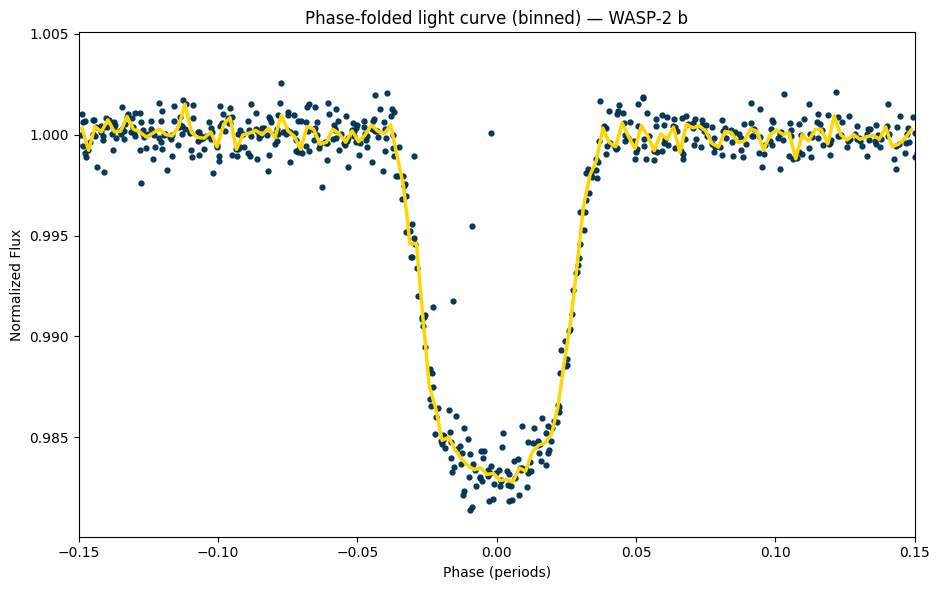

Measured depth ≈ 1.73%  (~17277 ppm)


In [17]:


import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt


planet_name = "WASP-2 b"
nbins       = 130
window      = (-0.15, 0.15)
clip_sigma  = 3.0

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl     = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header    = {}


def phase_bin(phase, flux, nbins=150, clip_sigma=3.0, window=(-0.15, 0.15)):
    """Robust median binning with optional MAD clip inside each bin."""
    ph = np.asarray(phase, float)
    y  = np.asarray(flux,  float)
    m  = np.isfinite(ph) & np.isfinite(y) & (ph >= window[0]) & (ph <= window[1])
    ph, y = ph[m], y[m]

    edges   = np.linspace(window[0], window[1], nbins+1)
    centers = 0.5*(edges[:-1] + edges[1:])
    y_med   = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (ph >= edges[i]) & (ph < edges[i+1])
        if not np.any(sel):
            continue
        vals = y[sel]
        if clip_sigma is not None and np.isfinite(vals).sum() > 5:
            med = np.nanmedian(vals)
            mad = 1.4826*np.nanmedian(np.abs(vals - med))
            if mad > 0:
                vals = vals[np.abs(vals - med) < clip_sigma*mad]
        if vals.size:
            y_med[i] = np.nanmedian(vals)
    return centers, y_med

def fetch_identifiers(name):
    url = planeturl + "/identifiers/"
    r = requests.get(url, params={"name": name}, headers=header, timeout=30)
    r.raise_for_status()
    j = r.json()
    return j["tessID"], j["tessTCE"]

def fetch_first_sector(ticid, tce):
    url = dvurl + f"{ticid}/tces/"
    r = requests.get(url, params={"tce": tce}, headers=header, timeout=30)
    r.raise_for_status()
    j = r.json()
    sectors = [x[:11] for x in j["TCE"] if tce in x]
    if not sectors:
        raise RuntimeError("No sectors returned for this TCE.")
    return sectors[0]

def fetch_dv_table(ticid, tce, sector):
    url = dvurl + f"{ticid}/table/"
    r = requests.get(url, params={"tce": tce, "sector": sector}, headers=header, timeout=60)
    r.raise_for_status()
    j = r.json()
    df = pd.DataFrame.from_dict(j["data"])
    return df


ticid, tce = fetch_identifiers(planet_name)
sector     = fetch_first_sector(ticid, tce)
df         = fetch_dv_table(ticid, tce, sector)

phase   = np.asarray(df["PHASE"], float)
relflux = np.asarray(df["LC_DETREND"], float)
model   = np.asarray(df["MODEL_INIT"], float)


oot_mask = (np.abs(phase) > 0.06) & (np.abs(phase) < 0.49) & np.isfinite(relflux)
baseline = np.nanmedian(relflux[oot_mask]) if np.any(oot_mask) else np.nanmedian(relflux)

flux_norm  = 1.0 + (relflux - baseline)
model_norm = 1.0 + (model   - baseline)


xc, yb = phase_bin(phase, flux_norm, nbins=nbins, clip_sigma=clip_sigma, window=window)


if np.isfinite(yb).any():
    oot_b = (np.abs(xc) > 0.06) & (np.abs(xc) < 0.49) & np.isfinite(yb)
    base  = np.nanmedian(yb[oot_b]) if np.any(oot_b) else np.nanmedian(yb)
else:
    base = 1.0


plt.figure(figsize=(9.5, 6.0))
plt.plot(phase, flux_norm, ".", ms=7, alpha=0.95, color="#003153")
plt.plot(xc, yb, "-", lw=2.5, color="#ffd700")

plt.xlim(*window)
plt.ylim(base - 0.020, base + 0.005)
plt.xlabel("Phase (periods)")
plt.ylabel("Normalized Flux")
plt.title(f"Phase-folded light curve (binned) — {planet_name}")
plt.tight_layout()
plt.show()

if np.isfinite(yb).any():
    core = np.abs(xc) < 0.01
    if np.any(core):
        depth = 1 - (np.nanmin(yb[core]) / base)
        print(f"Measured depth ≈ {depth*100:.2f}%  (~{depth*1e6:.0f} ppm)")

